# Customers and Products Analysis Using SQL

Addison 2022-08-16

## Introduction

This project aims to help a scale model car company identify: 

- which products should be ordered more

- which products should be ordered less

- which customer groups it should focus more marketing and communication on 

based on its sales records database. The dataset could be obtained through this link: https://drive.google.com/file/d/11i25XUua9jr8dJtMfxq6UcET3EQQNH7F/view?usp=sharing

This project will also examine the ratio of new customers and that of their payment as well as compute the Customer Lifetime Value (LTV), which denotes the average amount of profits a customer generates during their lifetime with the company.

In [1]:
%%capture
%load_ext sql
%sql sqlite:////Users/apple/stores.db

To start with, let's have a quick look at the components of the sales records database.

In [2]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table");

 * sqlite:////Users/apple/stores.db
Done.


name,type
customers,table
employees,table
offices,table
orderdetails,table
orders,table
payments,table
productlines,table
products,table


The image below is the database schema.

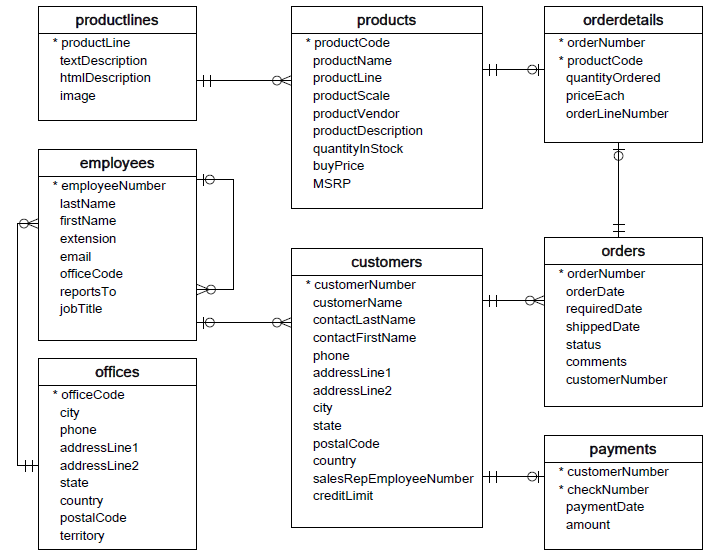

## Which products should be ordered more/less?

To identify which products should we order more of or less of, we should examine their stock level and sales performance.

In this project, the stock level **(stock_level)** is calculated by having in-stock quantity **(quantityInStock)** divided by ordered quantity **(quantityOrdered)** while the sales performance **(total_sales)** is the sum of each ordered quantity **(quantityOrdered)** multiplied by the price of the ordered product **(priceEach)**.

In [3]:
%%sql
SELECT p.productCode, p.productName, p.quantityInStock, o.total_order, s.stock_level, o.total_sales
FROM products p 
INNER JOIN
(SELECT p.productCode, ROUND(p.quantityInStock/SUM(CAST(o.quantityOrdered as Float)), 2) as stock_level
FROM products p 
INNER JOIN orderdetails o
ON p.productCode = o.productCode
GROUP BY p.productCode
ORDER BY stock_level) s
ON p.`productCode` = s.`productCode`
INNER JOIN 
(SELECT productCode, ROUND(SUM(quantityOrdered*priceEach), 2) as total_sales,  SUM(quantityOrdered) as total_order
FROM orderdetails
GROUP BY productCode
ORDER BY total_sales DESC) o
ON p.`productCode` = o.`productCode`
ORDER BY o.total_sales DESC
LIMIT 10
;

 * sqlite:////Users/apple/stores.db
Done.


productCode,productName,quantityInStock,total_order,stock_level,total_sales
S18_3232,1992 Ferrari 360 Spider red,8347,1808,4.62,276839.98
S12_1108,2001 Ferrari Enzo,3619,1019,3.55,190755.86
S10_1949,1952 Alpine Renault 1300,7305,961,7.6,190017.96
S10_4698,2003 Harley-Davidson Eagle Drag Bike,5582,985,5.67,170686.0
S12_1099,1968 Ford Mustang,68,933,0.07,161531.48
S12_3891,1969 Ford Falcon,1049,965,1.09,152543.02
S18_1662,1980s Black Hawk Helicopter,5330,1040,5.13,144959.91
S18_2238,1998 Chrysler Plymouth Prowler,4724,986,4.79,142530.63
S18_1749,1917 Grand Touring Sedan,2724,918,2.97,140535.6
S12_2823,2002 Suzuki XREO,9997,1028,9.72,135767.03


The table above shows the stock level and sales performance of the top ten best-sellers.

Overall, the stock level of the best-sellers is maintained at over 1 except the 1968 Ford Mustang. Specifically, while the stock level of the majority of top ten best-sellers is above 3, that of the 1969 Ford Falcon is just slightly above 1. Thus, it is suggested that the company should order more 1968 Ford Mustang and 1969 Ford Falcon	products to avoid a shortage of sales.

The company also should consider other factors such as transportation costs, transportation duration, and holding costs to decide whether to reduce orders of products a having stock level above 3 to reduce inventory costs.

In [4]:
%%sql
SELECT p.productCode, p.productName, p.quantityInStock, o.total_order, s.stock_level, o.total_sales
FROM products p 
INNER JOIN
(SELECT p.productCode, ROUND(p.quantityInStock/SUM(CAST(o.quantityOrdered as Float)), 2) as stock_level
FROM products p 
INNER JOIN orderdetails o
ON p.productCode = o.productCode
GROUP BY p.productCode
ORDER BY stock_level) s
ON p.`productCode` = s.`productCode`
INNER JOIN 
(SELECT productCode, ROUND(SUM(quantityOrdered*priceEach), 2) as total_sales,  SUM(quantityOrdered) as total_order
FROM orderdetails
GROUP BY productCode
ORDER BY total_sales DESC) o
ON p.`productCode` = o.`productCode`
WHERE stock_level < 1
ORDER BY s.stock_level, total_sales DESC
;

 * sqlite:////Users/apple/stores.db
Done.


productCode,productName,quantityInStock,total_order,stock_level,total_sales
S24_2000,1960 BSA Gold Star DBD34,15,1015,0.01,67193.49
S12_1099,1968 Ford Mustang,68,933,0.07,161531.48
S32_4289,1928 Ford Phaeton Deluxe,136,972,0.14,60493.33
S32_1374,1997 BMW F650 ST,178,1014,0.18,89364.89
S72_3212,Pont Yacht,414,958,0.43,47550.4
S700_3167,F/A 18 Hornet 1/72,551,1047,0.53,76618.4
S50_4713,2002 Yamaha YZR M1,600,992,0.6,73670.64
S18_2795,1928 Mercedes-Benz SSK,548,880,0.62,132275.98
S18_2248,1911 Ford Town Car,540,832,0.65,45306.77
S700_1938,The Mayflower,737,898,0.82,69531.61


The table above shows the stock level and sales performance of products having a stock level below 1.

Since these products also generate good amounts of sales for the company, it should place more orders of these products.

In [5]:
%%sql
SELECT p.productCode, p.productName, p.quantityInStock, o.total_order, s.stock_level, o.total_sales
FROM products p 
INNER JOIN
(SELECT p.productCode, ROUND(p.quantityInStock/SUM(CAST(o.quantityOrdered as Float)), 2) as stock_level
FROM products p 
INNER JOIN orderdetails o
ON p.productCode = o.productCode
GROUP BY p.productCode
ORDER BY stock_level) s
ON p.`productCode` = s.`productCode`
INNER JOIN 
(SELECT productCode, ROUND(SUM(quantityOrdered*priceEach), 2) as total_sales,  SUM(quantityOrdered) as total_order
FROM orderdetails
GROUP BY productCode
ORDER BY total_sales DESC) o
ON p.`productCode` = o.`productCode`
WHERE s.stock_level > 5
ORDER BY s.stock_level DESC, total_sales DESC
;

 * sqlite:////Users/apple/stores.db
Done.


productCode,productName,quantityInStock,total_order,stock_level,total_sales
S18_1984,1995 Honda Civic,9772,917,10.66,119050.95
S24_3432,2002 Chevy Corvette,9446,894,10.57,87404.81
S32_2206,1982 Ducati 996 R,9241,906,10.2,33268.76
S18_3482,1976 Ford Gran Torino,9127,915,9.97,121890.6
S18_1589,1965 Aston Martin DB5,9042,914,9.89,101778.13
S12_3380,1968 Dodge Charger,9123,925,9.86,98718.76
S700_2466,America West Airlines B757-200,9653,984,9.81,89347.8
S18_2325,1932 Model A Ford J-Coupe,9354,957,9.77,109992.01
S12_2823,2002 Suzuki XREO,9997,1028,9.72,135767.03
S18_2870,1999 Indy 500 Monte Carlo SS,8164,855,9.55,100770.12


The table above shows the stock level and sales performance of products having a stock level above 5.

The company should consider other factors such as transportation costs, transportation duration, and holding costs to decide whether to reduce orders of products having a stock level above 5 but generating sales below 100.000 to reduce inventory cost.

In [6]:
%%sql
SELECT p.productCode, p.productName, p.quantityInStock, o.total_order, s.stock_level, o.total_sales
FROM products p 
INNER JOIN
(SELECT p.productCode, ROUND(p.quantityInStock/SUM(CAST(o.quantityOrdered as Float)), 2) as stock_level
FROM products p 
INNER JOIN orderdetails o
ON p.productCode = o.productCode
GROUP BY p.productCode
ORDER BY stock_level) s
ON p.`productCode` = s.`productCode`
INNER JOIN 
(SELECT productCode, ROUND(SUM(quantityOrdered*priceEach), 2) as total_sales,  SUM(quantityOrdered) as total_order
FROM orderdetails
GROUP BY productCode
ORDER BY total_sales DESC) o
ON p.`productCode` = o.`productCode`
ORDER BY total_sales, s.stock_level DESC
LIMIT 10
;

 * sqlite:////Users/apple/stores.db
Done.


productCode,productName,quantityInStock,total_order,stock_level,total_sales
S24_1937,1939 Chevrolet Deluxe Coupe,7332,937,7.82,28052.94
S24_3969,1936 Mercedes Benz 500k Roadster,2081,824,2.53,29763.39
S24_2972,1982 Lamborghini Diablo,7723,912,8.47,30972.87
S24_2840,1958 Chevy Corvette Limited Edition,2542,983,2.59,31627.96
S32_2206,1982 Ducati 996 R,9241,906,10.2,33268.76
S24_2022,1938 Cadillac V-16 Presidential Limousine,2847,955,2.98,38449.09
S50_1341,1930 Buick Marquette Phaeton,7062,1074,6.58,41599.24
S24_1628,1966 Shelby Cobra 427 S/C,8197,915,8.96,42015.54
S72_1253,Boeing X-32A JSF,4857,960,5.06,42692.53
S18_4668,1939 Cadillac Limousine,6645,995,6.68,44037.84


The table above shows the stock level and sales performance of products generating the least sales and having the highest stock level.

The company should consider other factors such as transportation costs, transportation duration, and holding costs to decide whether to reduce orders of products having a stock level above 3 but generating the least sales to reduce inventory cost.

## Which customer groups should the company focus more marketing and communication on?

In [7]:
%%sql
SELECT o.customerNumber, c.customerName, c.country, ROUND(SUM(od.`quantityOrdered`*(od.`priceEach` - p.`buyPrice`)), 2) as profit
FROM orders o
INNER JOIN orderdetails od
ON o.`orderNumber` = od.`orderNumber`
INNER JOIN products p
ON od.`productCode` = p.`productCode`
INNER JOIN customers c
ON c.customerNumber = o.customerNumber
GROUP BY o.customerNumber
ORDER BY profit DESC
LIMIT 10;


 * sqlite:////Users/apple/stores.db
Done.


customerNumber,customerName,country,profit
141,Euro+ Shopping Channel,Spain,326519.66
124,Mini Gifts Distributors Ltd.,USA,236769.39
151,Muscle Machine Inc,USA,72370.09
114,"Australian Collectors, Co.",Australia,70311.07
119,La Rochelle Gifts,France,60875.3
148,"Dragon Souveniers, Ltd.",Singapore,60477.38
187,"AV Stores, Co.",UK,60095.86
323,"Down Under Souveniers, Inc",New Zealand,60013.99
131,Land of Toys Inc.,USA,58669.1
450,The Sharp Gifts Warehouse,USA,55931.37


The table above displays the most profitable customers, whom the company should prioritize communication and demand fulfilment over other groups of customers.

In [8]:
%%sql
SELECT o.customerNumber, c.customerName, c.country, ROUND(SUM(od.`quantityOrdered`*(od.`priceEach` - p.`buyPrice`)), 2) as profit
FROM orders o
INNER JOIN orderdetails od
ON o.`orderNumber` = od.`orderNumber`
INNER JOIN products p
ON od.`productCode` = p.`productCode`
INNER JOIN customers c
ON c.customerNumber = o.customerNumber
GROUP BY o.customerNumber
ORDER BY profit
LIMIT 10;

 * sqlite:////Users/apple/stores.db
Done.


customerNumber,customerName,country,profit
219,Boards & Toys Co.,USA,2610.87
198,Auto-Moto Classics Inc.,USA,6586.02
473,Frau da Collezione,Italy,9532.93
103,Atelier graphique,France,10063.8
489,"Double Decker Gift Stores, Ltd",UK,10868.04
381,Royale Belge,Belgium,11693.99
415,"Bavarian Collectables Imports, Co.",Germany,13033.35
456,Microscale Inc.,USA,13066.02
173,Cambridge Collectables Co.,USA,13734.7
347,"Men 'R' US Retailers, Ltd.",USA,14928.37


The table above displays the least profitable customers. The company should study why these customers are least engaged with it and try to solve the identified problems. If it can increase sales from these customers, it could encourage them to introduce the company to other potential partners by offering referral fees.

## Examining the ratio of new customers and that of their payment

Next, we are going to find out the number of new customers and the amount of payment made by them that the company acquired each month.

In [9]:
%%sql
WITH payment_by_month AS 
(SELECT SUBSTR(paymentDate, 1, 7) AS year_month, amount, customerNumber
FROM payments),

customers_by_month AS
(SELECT p.year_month , COUNT(*) AS num_customers, SUM(p.amount) AS total_payment
FROM payment_by_month p
GROUP BY p.year_month),

new_customers_by_month AS
(SELECT p.year_month, COUNT(*) AS num_new_customers, SUM(p.amount) AS payment_by_new_customers
FROM payment_by_month p
WHERE p.customerNumber NOT IN
(SELECT p1.customerNumber
FROM payment_by_month p1
WHERE p1.year_month < p.year_month)
GROUP BY p.year_month)


SELECT n.year_month ,  c.num_customers, c.total_payment,n.num_new_customers, n.payment_by_new_customers, 
ROUND(n.num_new_customers*1.0/c.num_customers*1.0,2) AS new_customer_ratio, ROUND(n.payment_by_new_customers/
                                                                                  c.total_payment,2)
AS payment_by_new_customers_ratio
FROM new_customers_by_month n
INNER JOIN customers_by_month c
ON c.year_month = n.year_month
ORDER BY n.year_month





 * sqlite:////Users/apple/stores.db
Done.


year_month,num_customers,total_payment,num_new_customers,payment_by_new_customers,new_customer_ratio,payment_by_new_customers_ratio
2003-01,3,26267.620000000003,3,26267.620000000003,1.0,1.0
2003-02,3,144384.36,3,144384.36,1.0,1.0
2003-03,5,199704.47999999998,5,199704.47999999998,1.0,1.0
2003-04,7,136313.91999999998,7,136313.91999999998,1.0,1.0
2003-05,6,159881.97000000003,6,159881.97000000003,1.0,1.0
2003-06,5,180218.97999999998,5,180218.97999999998,1.0,1.0
2003-07,8,158247.0,6,108075.71,0.75,0.68
2003-08,6,246204.86,4,133422.26,0.67,0.54
2003-09,5,161206.22999999998,4,154574.87,0.8,0.96
2003-10,13,316857.96,9,219683.03000000003,0.69,0.69


Here are the descriptions for columns of the table above:

**year_month:** period of time

**num_customers:** total number of customers

**total_payment:** total payment made by total customers

**num_new_customers:** number of new customers

**payment_by_new_customers:** total payments made by new customers

**new_customer_ratio:** the proportion between **num_new_customers:** and **num_customers**

**payment_by_new_customers_ratio:** the proportion between **payment_by_new_customers:** and **total_payment** 

From the table above, it is evident that **from 01/2003 to 06/2003**, all of the sales of the company came from its new customers (**payment_by_new_customers_ratio** = 1).

**From 07/2003 to 12/2003**, although the sales of the company did not from its new customers completely anymore, it was still greatly dependent on this type of customers (**payment_by_new_customers_ratio** > 0.5).

**From 01/2004 onwards except 03/2004 and 09/2004**, the sales of the company mostly came from its old customers (**payment_by_new_customers_ratio** < 0.5). This suggests that the company should acquire more new customers to expand its customer base as well as increase sales.

## Computing the Customer Lifetime Value (LTV)

To estimate the average amount of profits that a new customer can generate for the company, we are about to compute the Customer Lifetime Value (LTV), which denotes the average amount of profits a customer generates during their lifetime with the company.


In [10]:
%%sql
WITH profit_by_customer AS
(SELECT o.customerNumber, SUM(od.quantityOrdered*(od.priceEach - p.buyPrice)) AS profit
 FROM products p
 INNER JOIN orderdetails od
 ON p.productCode = od.productCode
 JOIN orders o
 ON o.orderNumber = od.orderNumber
 GROUP BY o.customerNumber)

SELECT ROUND(AVG(pc.profit),2) AS ltv
FROM profit_by_customer pc

 * sqlite:////Users/apple/stores.db
Done.


ltv
39039.59


This LTV suggests that the company should not spend over this amount to acquire a new customer while maintaining profitability.

## Conclusion

In conclusion, the company should 
- order more 1968 Ford Mustang and 1969 Ford Falcon products and those having a stock level below 1
- consider several factors such as transportation costs, transportation duration, and holding costs to decide whether to reduce orders of products having a stock level above 3 but generating the least sales and those having a stock level above 5 but generating sales below 100.000 to reduce inventory costs
- prioritize the most profitable group of customers over other groups of customers in terms of communication and demand fulfilment. Here are customer numbers of the top ten profitable customers: 141, 124, 151, 114, 19, 148, 187, 323, 131, and 450
- study the reasons behind low amount of sales from the least engaged customers and try to solve the identified problems. If it can increase sales from these customers, it could encourage them to introduce the company to other potential partners by offering referral fees. Here are customer numbers of the ten least profitable customers: 219, 198, 473, 103, 489, 381, 415, 456, 173, and 347
- not spend over $39039.59, which is its Customer Lifetime Value, to acquire a new customer while maintaining profitability.




